# COMP90051 Workshop 4
## Logistic regression
***
In this workshop we'll be implementing L2-regularised logistic regression using `scipy` and `numpy`. 
Our key objectives are:

* to become familiar with the optimisation problem that sits behind L2-regularised logistic regression;
* to apply polynomial basis expansion and recognise when it's useful; and
* to experiment with the effect of L2 regularisation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

### 1. Binary classification data
Let's begin by generating some binary classification data.
To make it easy for us to visualise the results, we'll stick to a two-dimensional feature space.

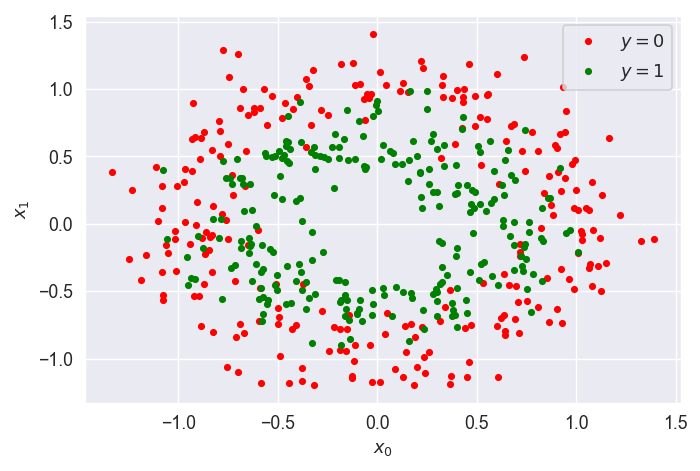

In [2]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

from sklearn.datasets import make_circles
X, Y = make_circles(n_samples=500, noise=0.17, factor=0.65, random_state=90051)
plt.plot(X[Y==0,0], X[Y==0,1], '.', label = "$y=0$", c='r')
plt.plot(X[Y==1,0], X[Y==1,1], '.', label = "$y=1$", c='g')
plt.legend()
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.show()

**Question:** What's interesting about this data? Do you think logistic regression will perform well?

**Answer:** *This question is answered in section 3.*

In preparation for fitting and evaluating a logistic regression model, we randomly partition the data into train/test sets. We use the `train_test_split` function from `sklearn`.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))

Training set has 400 instances. Test set has 100 instances.


## 2. Logistic Regression
In binary classification we receive training data $\mathcal{D} = \left((\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\right)$, where $\mathbf{x}_k \in \mathbb{R}^N$ denotes the feature vector associated with the $k$th training point and the targets $y \in \{0,1\}$. Logistic regression models the distribution of the binary target $y$ *conditional* on the feature vector $\mathbf{x}$ as

\begin{equation}
y | \mathbf{x} \sim \mathrm{Bernoulli}[\sigma(\mathbf{w}^T \mathbf{x} + b)]
\end{equation}

where $\mathbf{w} \in \mathbb{R}^N$ is the weight vector, $b \in \mathbb{R}$ is the bias term and $\sigma(z) = 1/(1 + e^{-z})$ is the logistic function. Note here our parameter of interest $\theta$ is the conditional probability of a particular instance belonging to class 1 given observation of the associated feature vector $\mathbf{x}$:

$$\theta = p(y = 1 \vert \mathbf{x}) = \sigma\left(\mathbf{w}^T \mathbf{x} + b\right) $$
To simplify the notation, we'll collect the model parameters $\mathbf{w}$ and $b$ in a single vector $\mathbf{v} = [b, \mathbf{w}]$. 

To find appropriate parameters $\mathbf{v}$, we want to maximize the log-likelihood with respect to $\mathbf{v}$, in lecture it was shown this is equivalent to minimization of the sum of cross-entropies over the instances ($i = 1,\ldots,n$) in the training set


$$
\mathcal{L}_{CE}(\mathbf{v}; \mathbf{x}, \mathbf{y}) = -\prod_{i=1}^n \log \left(p(y_i \vert \mathbf{x}_i\right) = - \sum_{i = 1}^{n} \left\{ y_i \log \sigma(\mathbf{w}^T \mathbf{x}_i + b) + (1 - y_i) \log (1 - \sigma(\mathbf{w}^T \mathbf{x}_i + b)) \right\}
$$

Often an L2 regularisation term of the form $\mathcal{L}_{\mathrm{reg}}(\mathbf{w}) = \frac{1}{2} \lambda \mathbf{w}^T \mathbf{w}$ is added to the objective to penalize large weights (this can help prevent overfitting to idiosycrancies in the training set). Note that $\lambda \geq 0$ controls the strength of the regularisation term.

Putting this together, our goal is to minimise the following objective function with respect to $\mathbf{v}$:
$$
\mathcal{L}(\mathbf{v}; \mathbf{x}, \mathbf{y}) = \mathcal{L}_\mathrm{reg}(\mathbf{w}) + \mathcal{L}_{CE}(\mathbf{v}; \mathbf{x}, \mathbf{y})
$$

***
#### **Exercise 1 (Discussion?):** 
The L2 regularization term  $\mathcal{L}_{\mathrm{reg}}(\mathbf{w}) = \frac{1}{2} \lambda \mathbf{w}^T \mathbf{w}$ is commonly said to reduce overfitting. Give a brief justification why?

#### **Exercise 2 (Discussion?):** 
Why do we only include the weights $\mathbf{w}$ in the L2 regularization term? i.e. the bias terms are excluded from regularization.

#### **Exercise 3:**
Given we model the conditional probability of label $y=1$ to be $p(y = 1 \vert \mathbf{x}) = \sigma\left(\mathbf{w}^T \mathbf{x} + b\right)$, show that prediction is based on a linear decision rule given by the sign of logarithm of the ratio of probabilities:

\begin{equation}
    \log \frac{p(y=1 \vert \mathbf{x})}{p(y=0 \vert \mathbf{x})} = \mathbf{w}^T \mathbf{x} + b
\end{equation}

This is why logistic regression is referred to as a _log-linear model_. What is the decision boundary for logistic regression? 
***

We're going to find a solution to this minimisation problem using the BFGS algorithm (named after the inventors Broyden, Fletcher, Goldfarb and Shanno). BFGS is a "hill-climbing" algorithm like gradient descent, however it additionally makes use of second-order derivative information (by approximating the Hessian). It converges in fewer iterations than gradient descent (it's convergence rate is *superlinear* whereas gradient descent is only *linear*).

We'll use an implementation of BFGS provided in `scipy` called `fmin_bfgs`. The algorithm requires two functions as input: (i) a function that evaluates the objective $f(\mathbf{v}; \ldots)$ and (ii) a function that evalutes the gradient $\nabla_{\mathbf{v}} f(\mathbf{v}; \ldots)$.

Let's start by writing a function to compute $f(\mathbf{v}; \ldots)$.

In [12]:
from scipy.special import expit # this is the logistic function
sigmoid = expit

# v: parameter vector
# X: feature matrix
# Y: class labels
# Lambda: regularisation constant
def obj_fn(v, X, Y, Lambda):
    prob_1 = sigmoid(np.dot(X,v[1::]) + v[0])
    reg_term = .5* Lambda * np.dot(v[1::],v[1::]) # fill in
    cross_entropy_term = - np.dot(Y, np.log(prob_1)) - np.dot(1. - Y, np.log(1. - prob_1))
    return (cross_entropy_term + cross_entropy)

Now for the gradient, we use the following result (if you're familiar with vector calculus, you may wish to derive this yourself):
$$
\nabla_{\mathbf{v}} f(\mathbf{v}; \ldots) = \left[\frac{\partial f(\mathbf{w}, b;\ldots)}{\partial b}, \nabla_{\mathbf{w}} f(\mathbf{w}, b; \ldots) \right] = \left[\sum_{i = 1}^{n} \sigma(\mathbf{w}^T \mathbf{x}_i + b) - y_i, \lambda \mathbf{w} + \sum_{i = 1}^{n} (\sigma(\mathbf{w}^T \mathbf{x}_i + b) - y_i)\mathbf{x}_i\right]
$$

The function below implements $\nabla_{\mathbf{v}} f(\mathbf{v}; \ldots)$.

In [13]:
# v: parameter vector
# X: feature matrix
# Y: class labels
# Lambda: regularisation constant
def grad_obj_fn(v, X, Y, Lambda):
    prob_1 = sigmoid(np.dot(X, v[1::]) + v[0])
    grad_b = np.sum(prob_1 - Y)
    grad_w = Lambda * v[1::] + np.dot(prob_1 - Y, X)
    return np.insert(grad_w, 0, grad_b)

### 3. Solving the minimization problem using BFGS

Now that we've implemented functions to compute the objective and the gradient, we can plug them into `fmin_bfgs`.
Specifically, we define a function `my_logistic_regression` which calls `fmin_bfgs` and returns the optimal weight vector.

In [14]:
from scipy.optimize import fmin_bfgs

# X: feature matrix
# Y: class labels
# Lambda: regularisation constant
# v_initial: initial guess for parameter vector
def my_logistic_regression(X, Y, Lambda, v_initial, disp=True):
    # Function for displaying progress
    def display(v):
        print('v is', v, 'objective is', obj_fn(v, X, Y, Lambda))
    
    return fmin_bfgs(f=obj_fn, fprime=grad_obj_fn, 
                     x0=v_initial, args=(X, Y, Lambda), disp=disp, 
                     callback=display)

Let's try it out!

In [15]:
Lambda = 1
v_initial = np.zeros(X_train.shape[1] + 1) # fill in a vector of zeros of appropriate length
# Hint: how many parameters in our model?
v_opt = my_logistic_regression(X_train, Y_train, Lambda, v_initial)

# Function to plot the data points and decision boundary
def plot_results(X, Y, v, trans_func = None):
    # Scatter plot in feature space
    plt.plot(X[Y==0,0], X[Y==0,1], '.', label = "$y=0$", c='r')
    plt.plot(X[Y==1,0], X[Y==1,1], '.', label = "$y=1$", c='g')
    
    # Compute axis limits
    x0_lower = X[:,0].min() - 0.1
    x0_upper = X[:,0].max() + 0.1
    x1_lower = X[:,1].min() - 0.1
    x1_upper = X[:,1].max() + 0.1
    
    # Generate grid over feature space
    x0, x1 = np.mgrid[x0_lower:x0_upper:.01, x1_lower:x1_upper:.01]
    grid = np.c_[x0.ravel(), x1.ravel()]
    if (trans_func is not None):
        grid = trans_func(grid) # apply transformation to features
    arg = (np.dot(grid, v[1::]) + v[0]).reshape(x0.shape)
    
    # Plot decision boundary (where w^T x + b == 0)
    plt.contour(x0, x1, arg, levels=[0], cmap="Greys", vmin=-0.2, vmax=0.2)
    plt.legend()
    plt.show()
    
plot_results(X, Y, v_opt)

NameError: name 'cross_entropy' is not defined

**Question:** Is the solution what you expected? Is it a good fit for the data?

**Answer:** *It's not a good fit because logistic regression is a linear classifier, and the data is not linearly seperable.*

**Question:** What's the accuracy of this model? Fill in the code below assuming the following decision function
$$
\hat{y} = \begin{cases}
    1, &\mathrm{if} \ p(y = 1|\mathbf{x}) \geq \tfrac{1}{2}, \\
    0, &\mathrm{otherwise}.
\end{cases}
$$

In [ ]:
from sklearn.metrics import accuracy_score

def get_predictions(v_opt, X_test):
    #  Implement the logistic regression prediction rule here
    """
    Inputs:
    v_opt:        Optimized weights, shape [n+1]
                  Should contain bias term as zeroth element
    X_test:       Testing data, shape [N_test, n]
    
    Outputs:
    Y_test_pred:  Vector of predictions for given test instances
    """
    w = ...
    b = ...
    y_prob = ...
    Y_test_pred = ... # Returns boolean array, which we cast to float
    
    return Y_test_pred

Y_test_pred = get_predictions(v_opt, X_test)

print('Accuracy achieved: {:.3f}'.format(accuracy_score(Y_test, Y_test_pred)))

Writing nice docstrings allows your code to be self-documenting! :) 

In [19]:
get_predictions?

Object `get_predictions` not found.


### 4. Adding polynomial features

We've seen that ordinary logistic regression does poorly on this data set, because the data is not linearly separable in the $x_0,x_1$ feature space.

We can get around this problem using basis expansion. In this case, we'll augment the feature space by adding polynomial features of degree 2. In other words, we replace the original feature matrix $\mathbf{X}$ by a transformed feature matrix $\mathbf{\Phi}$ which contains additional columns corresponding to $x_0^2$, $x_0 x_1$ and $x_1^2$. This is done using the function `add_quadratic_features` defined below.

**Note:** There's a built-in function in `sklearn` for adding polynomial features located at `sklearn.preprocessing.PolynomialFeatures`.

In [16]:
# X: original feature matrix
def add_quadratic_features(X):
    return np.c_[X, X[:,0]**2, X[:,0]*X[:,1], X[:,1]**2]

Phi_train = add_quadratic_features(X_train)
Phi_test = add_quadratic_features(X_test)

Lets check the shape of the augmented feature matrix $\Phi$, is it what you expect?

In [17]:
print(r'Shape of Phi:', Phi_train.shape)

Shape of Phi: (400, 5)


Let's apply our custom logistic regression function again on the augmented feature space.

In [18]:
Lambda = 1
v_initial = np.zeros(Phi_train.shape[1] + 1) # fill in a vector of zeros of appropriate length
v_opt_phi = my_logistic_regression(Phi_train, Y_train, Lambda, v_initial)
plot_results(X, Y, v_opt_phi, trans_func=add_quadratic_features)

NameError: name 'cross_entropy' is not defined

This time we should get a better result for the accuracy on the test set.

In [ ]:
from sklearn.metrics import accuracy_score
Y_test_pred = ...  # fill in
print('Accuracy achieved: {:.3f}'.format(accuracy_score(Y_test, Y_test_pred)))

### 5. Effect of regularisation

So far, we've fixed the regularisation constant so that $\lambda = 1$. (Note it's possible to choose an "optimal" value for $\lambda$ by applying cross-validation.)

**Question:** What do you think will happen if we switch the regularisation off? Try setting $\lambda$ to a small value (say $10^{-3}$) and check whether the accuracy of the model is affected. You may wish to scan across a range of values for $\lambda$ and observe which value gives you the best accuracy on the test set.

**Answer:** *Generally speaking, we risk overfitting if the regularisation constant is too small (or switched off entirely). You should observe that the accuracy on the test set reduces slightly with $\lambda = 10^{-3}$ vs. $\lambda = 1$.*

### 6. Logistic regression using sklearn

Now that you have some insight into the optimisation problem behind logistic regression, you should feel confident in using the built-in implementation in `sklearn` (or other packages).
Note that the `sklearn` implementation handles floating point underflow/overflow more carefully than we have done, and uses faster numerical optimisation algorithms.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1)
clf.fit(Phi_train, Y_train)

In [ ]:
from sklearn.metrics import accuracy_score
Y_test_pred = clf.predict(Phi_test)
accuracy_score(Y_test, Y_test_pred)

### Bonus
#### **Exercise 4**
Consider how you would extend logistic regression to the multiclass case where $y \in \{c_1, \ldots c_m\}$. How would you model the conditional probability for class $k$: $p(y=c_k \vert \mathbf{x})$?